# Imports

In [2]:
# General imports
import os
import sys
import glob
from pathlib import Path
from datetime import datetime

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# Specialised
import mne


# Model Comparisons

In [3]:
# Get all the model evaluation run results and combine into a single df
#

data_folder_path = utils.get_folder_path('Model Comparisons')
file_name_pattern = '**/models_results_df**.pkl'
data_files = glob.glob(str(Path(data_folder_path) / file_name_pattern), recursive=True)

df_list = []
for next_file in data_files:
    df = pd.read_pickle(next_file, compression='zip')
    df_list.append(df)
models_evaluations_df = pd.concat(df_list, ignore_index=True)

print(models_evaluations_df.shape)
display(models_evaluations_df.head())


(33, 16)


,study,training_source_data_run,training_results_run,search_features_detail,search_features_selection,CV_search_time,CV_best_parameters,features_detail,features_selection,model_name,prediction_time,mcc,recall,precision,f1_score,specificity
0,IOWA_Rest,1b_EEG_Features_Results_Run_20250801_full_run,(2_Feature_Selection_Training_Run_20250812_sea...,"([region],)","([[cf, pw, bw]],)",7.889680,"{'classifier__criterion': 'entropy', 'classifi...",region,"[cf, pw, bw]",RandomForest_v1,0.053513,0.438086,1.000000,0.703704,0.826087,0.272727
1,IOWA_Rest,1b_EEG_Features_Results_Run_20250801_full_run,(2_Feature_Selection_Training_Run_20250812_sea...,"([region],)","([[cf, pw, bw]],)",4.764382,"{'classifier__C': 10, 'classifier__class_weigh...",region,"[cf, pw, bw]",LogisticRegression_v1,0.081201,0.234413,0.842105,0.695652,0.761905,0.363636
2,IOWA_Rest,1b_EEG_Features_Results_Run_20250801_full_run,(2_Feature_Selection_Training_Run_20250812_sea...,"([region],)","([[cf, pw, bw]],)",4.492693,"{'classifier__activation': 'tanh', 'classifier...",region,"[cf, pw, bw]",MLPClassifier_v1,0.026388,0.323268,0.842105,0.727273,0.780488,0.454545
3,IOWA_Rest,1b_EEG_Features_Results_Run_20250801_full_run,(2_Feature_Selection_Training_Run_20250812_sea...,"([channel],)","([[cf, pw, bw]],)",9.475886,"{'classifier__criterion': 'entropy', 'classifi...",channel,"[cf, pw, bw]",RandomForest_v1,0.062812,0.569378,0.842105,0.842105,0.842105,0.727273
4,IOWA_Rest,1b_EEG_Features_Results_Run_20250801_full_run,(2_Feature_Selection_Training_Run_20250812_sea...,"([channel],)","([[cf, pw, bw]],)",68.521576,"{'classifier__C': 1, 'classifier__class_weight...",channel,"[cf, pw, bw]",LogisticRegression_v1,0.012745,0.295790,0.578947,0.785714,0.666667,0.727273


In [4]:
# Export The Entire DF to CSV

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
csv_filename = f"Model_Comparisons_DF_{timestamp}.csv"
csv_filepath = os.path.join(data_folder_path, csv_filename)
if os.path.exists(csv_filepath):
    raise FileExistsError(f'File Exists: {csv_filepath}')

models_evaluations_df.to_csv(csv_filepath, index=False)

print(f"Successfully exported to CSV: {csv_filename}")
print(f"Total rows exported: {len(models_evaluations_df)}")
print(f"File location: {csv_filepath}")

Successfully exported to CSV: Model_Comparisons_DF_20250815_1217.csv
Total rows exported: 33
File location: /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/Model Comparisons/Model_Comparisons_DF_20250815_1217.csv


# Importance & Topographic Map

In [6]:
# Load SHAP importance CSV file into a df

data_folder_path = utils.get_folder_path('Model Comparisons')
shap_csv_pattern = '**/shap_importance_df**.csv'
shap_files = glob.glob(str(Path(data_folder_path) / shap_csv_pattern), recursive=True)
importance_df = pd.read_csv(shap_files[0])

# Tidy up the fature names
if 'feature' in importance_df.columns:
    importance_df['feature'] = importance_df['feature'].str.replace('numeric__channel_', '', regex=False)

print(importance_df.shape)
display(importance_df.head())


(1152, 2)


,feature,importance_%
0,O2_cf_0,9.971469
1,PO8_cf_0,8.372659
2,P6_cf_0,6.548290
3,P7_cf_0,5.818461
4,CP4_cf_0,4.905759


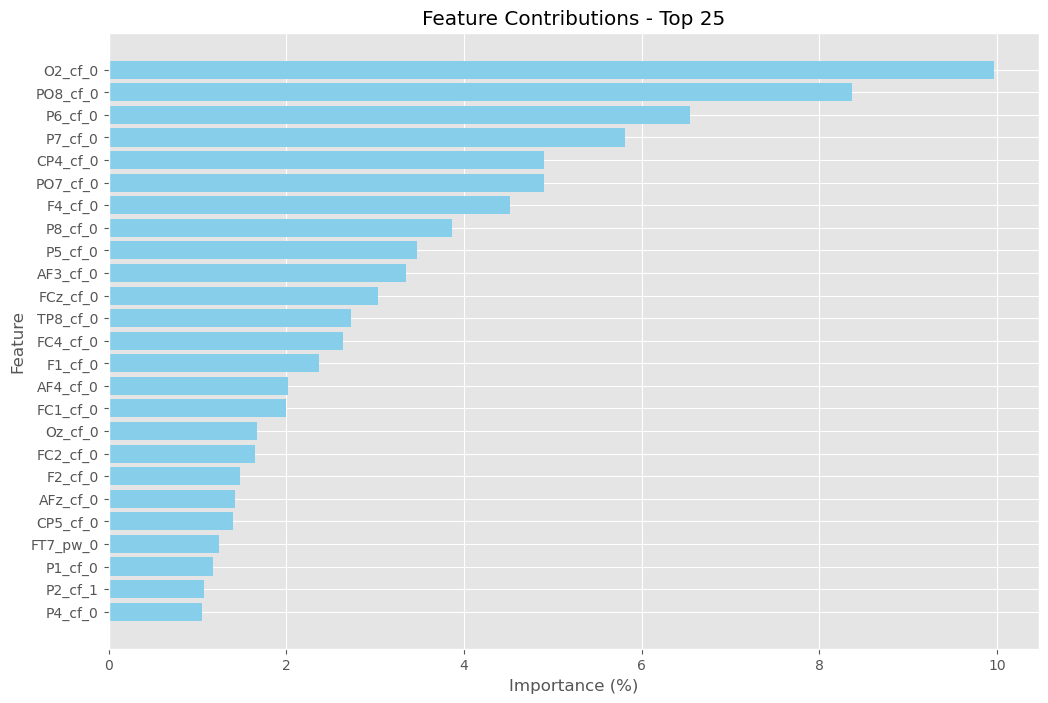

In [13]:
# Plot the top 25 Features

count = 25
plot_df = importance_df.head(count)
plt.figure(figsize=(12, 8))
plt.barh(plot_df['feature'], plot_df['importance_%'], color='skyblue')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.title(f'Feature Contributions - Top {count}')
plt.gca().invert_yaxis() 
plt.show()

In [ ]:
# Get the CF_0 features for a topgraphic plot

cf_df = importance_df[importance_df['feature'].str.contains('_cf_0', na=False)].copy()
if 'feature' in cf_df.columns:
    cf_df['feature'] = cf_df['feature'].str.replace('_cf_0', '', regex=False)

# Load standard montage & check electrodes overlap
montage = mne.channels.make_standard_montage('standard_1020')
available_electrodes = set(montage.ch_names)
target_electrodes = set(cf_df['feature'])
coverage = target_electrodes.intersection(available_electrodes)
print(f"Coverage: {len(coverage)}/{len(target_electrodes)} electrodes")



Coverage: 64/64 electrodes


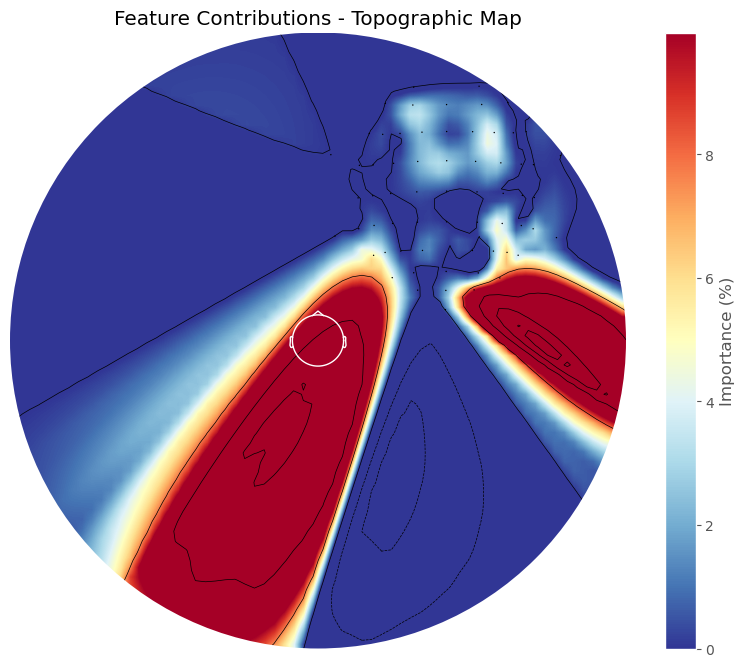

In [ ]:
# Plot the Importance

# Extract electrode positions for topographic plotting
electrode_list = cf_df['feature'].tolist()
info = mne.create_info(
    ch_names=electrode_list,
    sfreq=1000,  # Dummy sampling frequency
    ch_types='eeg'
)
info.set_montage(montage)
pos = mne.find_layout(info).pos

# Generate topographic map
importance_values = cf_df['importance_%'].values
fig, ax = plt.subplots(figsize=(10, 8))
im, _ = mne.viz.plot_topomap(
    data=importance_values,
    pos=pos,  # Use positions instead of info
    axes=ax,
    cmap='RdYlBu_r',
    contours=6,
    show=False
)
# Enhance visualization
ax.set_title('Feature Contributions - Topographic Map')
plt.colorbar(im, label='Importance (%)')
plt.show()